In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import bz2
import itertools
from time import time

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

import numpy as np
import lxml.etree

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# Get a Common Vocabulary

In [5]:
n_features = 20000

In [18]:
all_abstracts = !xmllint --shell ../data/simplewiki-latest-abstract.xml.gz <<< "cat //doc/abstract"

In [19]:
all_abstracts = all_abstracts[1::2]
len(all_abstracts)

130870

In [20]:
all_abstracts[:5]

['<abstract>April is the 4th month of the year, and comes between March and May. It is one of four months to have 30 days.</abstract>',
 '<abstract>August (Aug.) is the 8th month of the year in the Gregorian calendar, coming between July and September.</abstract>',
 '<abstract>Art is a creative activity by people.  These people are called artists.</abstract>',
 '<abstract>A is the first letter of the English alphabet. The small letter, a, is used as a lower case vowel.</abstract>',
 '<abstract>thumb|240px|This is what the air is made of</abstract>']

In [21]:
vectorizer0 = TfidfVectorizer(max_df=.95, min_df=1,
                              max_features=n_features,
                              lowercase=False,
                              stop_words='english')
vectorizer0.fit(all_abstracts)
vocabulary0 = vectorizer0.vocabulary_

# Read and Vectorise Documents

Simple Wiki's articles

In [4]:
def articles_iter(dump='../data/simplewiki-latest-pages-articles.xml.bz2',
                  keyphrase=None):
    ''' Extract pages with keyphrase '''
    with bz2.open(dump) as pages:
        tree = lxml.etree.ElementTree(file=pages)
        for node in tree.iter(tag='{*}text'):
            if node.text is None:
                continue
            if keyphrase is None:
                yield node.text
            elif keyphrase in node.text:
                yield node.text

TF-IDF Vectoriser

In [7]:
docs = list(articles_iter(keyphrase='United States'))
len(docs)

30285

In [22]:
tfidf_vectorizer = TfidfVectorizer(max_df=.95, min_df=1,
                                   max_features=n_features,
                                   lowercase=False,
                                   stop_words='english',
                                   vocabulary=vocabulary0)
tfidf_vectorizer.fit(docs)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=0.95, max_features=20000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary={'April': 1545, '4th': 919, 'month': 16237, 'year': 19948, 'comes': 12685, 'March': 6900, 'May': 7036, 'It': 5717, 'months': 16239, '30': 746, 'days': 13200, 'August': 1715, '8th': 1086, 'Gregorian': 4915, 'calendar': 12207, 'coming': 12691, 'July': 5939, 'September': 9358, 'Art': 1629, '...usa': 1860, 'Arthrostylidium': 1631, 'Losser': 6607, 'Zorlu': 11154, 'Takam': 10011, 'Parvat': 8179})

In [23]:
tfidf = tfidf_vectorizer.transform(docs)
tfidf.shape

(30285, 20000)

TF Vectoriser

In [24]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=1,
                                max_features=n_features,
                                lowercase=False,
                                stop_words='english',
                                vocabulary=tfidf_vectorizer.vocabulary_)
tf_vectorizer.fit(docs)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=0.95, max_features=20000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None,
        vocabulary={'April': 1545, '4th': 919, 'month': 16237, 'year': 19948, 'comes': 12685, 'March': 6900, 'May': 7036, 'It': 5717, 'months': 16239, '30': 746, 'days': 13200, 'August': 1715, '8th': 1086, 'Gregorian': 4915, 'calendar': 12207, 'coming': 12691, 'July': 5939, 'September': 9358, 'Art': 1629, '...usa': 1860, 'Arthrostylidium': 1631, 'Losser': 6607, 'Zorlu': 11154, 'Takam': 10011, 'Parvat': 8179})

In [25]:
tf = tf_vectorizer.transform(docs)
tf.shape

(30285, 20000)

# Topic Modelling

In [14]:
def print_top_words_factors(factors, feature_names, n_top_words):
    ''' Print top words of each topic '''
    for topic_idx, topic in enumerate(factors):
        message = f"Topic #{topic_idx}: "
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

def print_top_words(model, feature_names, n_top_words):
    ''' Print top words of each topic '''
    print_top_words_factors(model.components_, feature_names, n_top_words)

## NMF

In [26]:
nmf = NMF(n_components=10, init='random', alpha=.3, l1_ratio=1e-6)
nmf.fit(.8 * tfidf + .2 * tf)
print_top_words(nmf, tfidf_vectorizer.get_feature_names(), n_top_words=20)

Topic #0: http com www title url accessdate The web publisher date news 2011 American https work 2010 2016 2012 2013 dies
Topic #1: font User talk color UTC article style The small face Special 2009 Wikipedia page think 2008 articles user 2011 just
Topic #2: sort row Canada Cup Stanley Finals hockey ice Red Wings alt style 10 SC Won background 12 14 United States
Topic #3: align center left text small right style flag km2 row Florida film 000 convert width web 2010 The publisher Chart
Topic #4: Prix Grand small left align F1 Formula One style background flag Ferrari season engine Italian British 10 Monaco 12 German
Topic #5: FA The film battleship Battle album Hurricane class New John HMS William USS Park game born song War video History
Topic #6: li em 39 Angela User 91 2004 content 18 Dec 2003 Talk 02 Special 123 10 Jan Category Wikipedia 13
Topic #7: style background link text color File The size svg film px alt Line 10 Metro width Flag switch height 16
Topic #8: replace word ing 99

In [27]:
nmf = NMF(n_components=10, init='random', alpha=.3, l1_ratio=1e-6)
nmf.fit(.2 * tfidf + .8 * tf)
print_top_words(nmf, tfidf_vectorizer.get_feature_names(), n_top_words=20)

Topic #0: font User talk color UTC style The article small 2009 face Special Wikipedia 2008 page think articles user 2011 just
Topic #1: replace word ing 999 ed ly es al er don source match Un ei en ion ions ve In ar
Topic #2: United States Army style center background Private File Navy Sergeant Union First Battle The Medal jpg Honor link John born
Topic #3: sort row Canada Cup Stanley Finals hockey ice Red Wings alt background style 10 SC Won 12 14 United 11
Topic #4: FA The film battleship Battle album Hurricane class John New HMS William USS Park game War song born video History
Topic #5: li em 39 Angela User 91 2004 content 18 Dec 2003 Talk 02 Special 123 10 Jan Category Wikipedia 13
Topic #6: Prix Grand small style background left align F1 Formula One 10 Ferrari season engine 12 11 flag Italian British Monaco
Topic #7: align center style text left small film right flag km2 The row Florida width 000 convert web background 2010 publisher
Topic #8: http com www title url accessdate T

In [28]:
nmf = NMF(n_components=10, init='random', alpha=.3, l1_ratio=1e-6)
nmf.fit(tf)
print_top_words(nmf, tfidf_vectorizer.get_feature_names(), n_top_words=20)

Topic #0: http com www title url accessdate The web publisher date news 2011 American https work 2010 2012 2016 2013 dies
Topic #1: align center left text small style right flag km2 row Florida film 000 convert width web 2010 The publisher Chart
Topic #2: font User talk color UTC article style The small face Special 2009 Wikipedia page think 2008 articles user 2011 just
Topic #3: replace word ing 999 ed ly es al er don source match Un ei en ion ions ve In ar
Topic #4: Prix Grand small left align F1 Formula One style background flag Ferrari season engine Italian British 10 12 Monaco German
Topic #5: sort row Canada Cup Stanley Finals hockey ice Red Wings alt style 10 background SC Won 12 14 United States
Topic #6: li em 39 Angela User 91 2004 content 18 Dec 2003 Talk 02 Special 123 10 Jan Category Wikipedia 13
Topic #7: United States Army County center born Private New Navy Sergeant Alabama Union First American Jersey Battle Medal John jpg Honor
Topic #8: FA The film battleship Battle a

## Latent Dirichlet Allocation

Variational Inference for LDA

In [40]:
lda = LatentDirichletAllocation(n_components=10,
                                doc_topic_prior=1,
                                topic_word_prior=1,
                                max_iter=10,
                                learning_method='online')
lda.fit(tf)
print_top_words(lda, tf_vectorizer.get_feature_names(), n_top_words=20)

Topic #0: The In people wikt He It book This called They time language year org http author used government books did
Topic #1: American born actor dies The actress British singer politician player German English French FA John writer United people 2014 President
Topic #2: New Category York Jersey California University City Chicago River Texas State San Illinois Park National League United The States North
Topic #3: http www com title url accessdate web publisher date news https 2011 2012 2016 2015 2014 2010 work 2013 The
Topic #4: align center style small left background Grand text Prix sort flag width right 10 Canada United row One season 11
Topic #5: States United Category He Party American Army January jpg Republican Democratic US President date John births War File age University
Topic #6: The Category movie American album movies music series It film television com song Award Records United TV released States Best
Topic #7: User font talk color UTC style article The page Wikipedia

In [42]:
lda = LatentDirichletAllocation(n_components=10,
                                doc_topic_prior=.8,
                                topic_word_prior=.8,
                                max_iter=10,
                                learning_method='online')
lda.fit(tf)
print_top_words(lda, tf_vectorizer.get_feature_names(), n_top_words=20)

Topic #0: The United Army War States Union Battle German World France Germany French Navy British English South Republic language File II
Topic #1: The Category movie American music album movies film series It television com song Award Records United TV released States artist
Topic #2: http www com title url accessdate web publisher date news https 2016 2011 org 2012 work The 2015 2010 2013
Topic #3: Grand Prix small season team World WWE Championship FA Category League One Wrestling Formula football Team Cup match F1 United
Topic #4: User font talk color UTC style article The page Wikipedia Special articles small user think 2009 English face just don
Topic #5: County States United New Category state city US Jersey City State Area code Florida North River Alabama Texas Census Virginia
Topic #6: The In people wikt It They This called He United States year time book used author journal like pages did
Topic #7: Category American States United He born Party New John actor President January

## Spectral LDA

In [29]:
import sys
sys.path.insert(0, '../SpectralLDA')

from spectral_lda import spectral_lda

Using mxnet backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using numpy backend.


In [30]:
alpha, beta = spectral_lda(tf, alpha0=10, k=10)
print_top_words_factors(beta.T, tf_vectorizer.get_feature_names(), 20)

# docs: 30285	# valid: 30259


Topic #0: States American state movies California movie Florida deaths television New seats He Illinois nationality Idaho structures Sports Movies Geography Counties
Topic #1: Kentucky County Category United geo Cities city States US New seats Oklahoma county York Texas Idaho seat state Illinois Ohio
Topic #2: Category States United American state Party California New establishments category country President century History deaths nationality structures Geography York Constitution
Topic #3: Category States United Florida Cities geo city Idaho towns Illinois County Oklahoma Arkansas US Kentucky state Indiana Virginia America county
Topic #4: Category Party President Census dollar Rights Bill Constitution The Senate Army Republican Secretary Flag 2010 Department presidential List units customary
Topic #5: US The American http movie com www movies New title url television York date accessdate series publisher web music He
Topic #6: geo The http www com title American url He date accessda

In [46]:
alpha, beta = spectral_lda(tf, alpha0=5, k=10)
print_top_words_factors(beta.T, tf_vectorizer.get_feature_names(), 20)

# docs: 30285	# valid: 30259


Topic #0: Category geo Cities city United States Florida County Kentucky towns Idaho Illinois Virginia Oklahoma state Arkansas Indiana seats county town
Topic #1: States American state movies California Florida movie deaths Illinois television He seats Idaho structures Sports nationality Geography New Counties Movies
Topic #2: Category States United state American Party California establishments New category country President History century deaths structures nationality Geography Constitution Counties
Topic #3: Kentucky Category County United States geo Cities city US New seats York Oklahoma county Idaho Texas state Florida Iowa seat
Topic #4: Category Party President Census dollar Rights Bill Constitution The Senate Army 2010 Secretary Republican Flag Department presidential List units customary
Topic #5: US Iowa American The http movie com movies www New title television York url date accessdate series He web publisher
Topic #6: geo The http www com title url He accessdate date web 

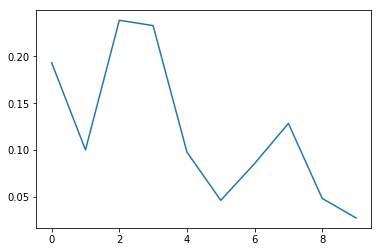

In [47]:
plt.plot(alpha)

In [48]:
alpha.sum()

1.1993758254776132